*Libraries Used :*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Predicting Facial Keypoints using a Pre-Trained Convolutional Neural Network

In [3]:
data_dir = 'gdrive/MyDrive/Year 4/StatisticalLearning/FinalProject/'

In [4]:
#Reading in the data
df_train = pd.read_csv(data_dir + 'training.csv')
df_test = pd.read_csv(data_dir + 'test.csv')

#Getting the validation dataset
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=1) #Split x train into 2 pieces 

In [5]:
#Shape of Train and Test
print('Train -->' , df_train.shape)
print('Validation -->' , df_val.shape)

Train --> (5286, 31)
Test --> (1783, 2)
Validation --> (1763, 31)


**Imputing Missing Values**

In [6]:
#Number of null values in each column
df_train.isna().sum() #Impute values 

left_eye_center_x               8
left_eye_center_y               8
right_eye_center_x              8
right_eye_center_y              8
left_eye_inner_corner_x      3561
left_eye_inner_corner_y      3561
left_eye_outer_corner_x      3562
left_eye_outer_corner_y      3562
right_eye_inner_corner_x     3559
right_eye_inner_corner_y     3559
right_eye_outer_corner_x     3560
right_eye_outer_corner_y     3560
left_eyebrow_inner_end_x     3562
left_eyebrow_inner_end_y     3562
left_eyebrow_outer_end_x     3598
left_eyebrow_outer_end_y     3598
right_eyebrow_inner_end_x    3560
right_eyebrow_inner_end_y    3560
right_eyebrow_outer_end_x    3589
right_eyebrow_outer_end_y    3589
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          3561
mouth_left_corner_y          3561
mouth_right_corner_x         3559
mouth_right_corner_y         3559
mouth_center_top_lip_x       3556
mouth_center_top_lip_y       3556
mouth_center_bottom_lip_x      24
mouth_center_b

In [7]:
#Number of null values in validation set 
df_val.isna().sum() 

left_eye_center_x               2
left_eye_center_y               2
right_eye_center_x              5
right_eye_center_y              5
left_eye_inner_corner_x      1217
left_eye_inner_corner_y      1217
left_eye_outer_corner_x      1220
left_eye_outer_corner_y      1220
right_eye_inner_corner_x     1222
right_eye_inner_corner_y     1222
right_eye_outer_corner_x     1221
right_eye_outer_corner_y     1221
left_eyebrow_inner_end_x     1217
left_eyebrow_inner_end_y     1217
left_eyebrow_outer_end_x     1226
left_eyebrow_outer_end_y     1226
right_eyebrow_inner_end_x    1219
right_eyebrow_inner_end_y    1219
right_eyebrow_outer_end_x    1224
right_eyebrow_outer_end_y    1224
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          1219
mouth_left_corner_y          1219
mouth_right_corner_x         1220
mouth_right_corner_y         1220
mouth_center_top_lip_x       1218
mouth_center_top_lip_y       1218
mouth_center_bottom_lip_x       9
mouth_center_b

In [8]:
#Impute Missing values from the training and validation set 
df_train.fillna(df_train.median(), inplace = True)
df_val.fillna(df_train.median(), inplace = True)

**Plotting an Image from the Training Dataset**

In [9]:
#Image column from training set which containes the image details
df_train[['Image']] 

,Image
6105,15 22 21 20 32 26 22 15 59 53 28 33 32 31 30 4...
3771,164 235 238 232 240 237 231 239 231 222 205 19...
1228,24 24 23 30 51 74 87 95 97 99 98 99 102 101 10...
6469,171 171 172 171 171 170 167 166 171 167 161 16...
289,168 154 141 126 117 122 125 117 101 113 132 12...
...,...
905,197 199 198 199 199 198 197 197 197 197 196 19...
5192,4 9 11 0 6 8 0 10 16 34 63 46 48 50 67 60 76 6...
3980,103 120 103 105 114 108 93 88 107 119 122 129 ...
235,186 189 187 189 184 166 128 89 68 60 60 62 58 ...


In [10]:
#Splitting the 'Image' column by a space and placing it in a new column
df_train['clean_img'] = df_train['Image'].str.split(' ')

In [11]:
#Gets the image values into an array
img  = [] #An array containing the image values 
for x in df_train['clean_img']:
    img.append(np.array(x, dtype=np.float32))

In [12]:
#Reshaping the image values into 96x96 and appending these values into array called new_img
new_img = []
for x in img:
    new_img.append(x.reshape(96,96))

In [13]:
images = df_train['clean_img']
images

6105    [15, 22, 21, 20, 32, 26, 22, 15, 59, 53, 28, 3...
3771    [164, 235, 238, 232, 240, 237, 231, 239, 231, ...
1228    [24, 24, 23, 30, 51, 74, 87, 95, 97, 99, 98, 9...
6469    [171, 171, 172, 171, 171, 170, 167, 166, 171, ...
289     [168, 154, 141, 126, 117, 122, 125, 117, 101, ...
                              ...                        
905     [197, 199, 198, 199, 199, 198, 197, 197, 197, ...
5192    [4, 9, 11, 0, 6, 8, 0, 10, 16, 34, 63, 46, 48,...
3980    [103, 120, 103, 105, 114, 108, 93, 88, 107, 11...
235     [186, 189, 187, 189, 184, 166, 128, 89, 68, 60...
5157    [28, 27, 26, 26, 27, 29, 31, 34, 36, 38, 41, 4...
Name: clean_img, Length: 5286, dtype: object

In [14]:
#The index we are looking at 
idx =8

row = df_train.iloc[idx]

#Getting the first 30 columns 
y = row[0:30]

#Data for a row 
y

left_eye_center_x            66.4373
left_eye_center_y            35.2478
right_eye_center_x           30.6998
right_eye_center_y           35.5586
left_eye_inner_corner_x      59.3271
left_eye_inner_corner_y      37.9068
left_eye_outer_corner_x      73.1662
left_eye_outer_corner_y      37.6502
right_eye_inner_corner_x      36.621
right_eye_inner_corner_y     37.9495
right_eye_outer_corner_x      22.563
right_eye_outer_corner_y     37.8747
left_eyebrow_inner_end_x     56.2684
left_eyebrow_inner_end_y      29.549
left_eyebrow_outer_end_x     79.7681
left_eyebrow_outer_end_y      29.799
right_eyebrow_inner_end_x    39.3173
right_eyebrow_inner_end_y    29.5668
right_eyebrow_outer_end_x    15.8513
right_eyebrow_outer_end_y    30.3039
nose_tip_x                   49.0347
nose_tip_y                   56.6904
mouth_left_corner_x          63.1275
mouth_left_corner_y          75.7867
mouth_right_corner_x         32.9794
mouth_right_corner_y         76.0065
mouth_center_top_lip_x       47.8444
m

*Image with Facial Keypoints from the Training Set*

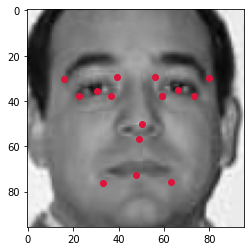

In [15]:
#Plotting the Facial Data Points
plt.scatter(y.left_eye_center_x, y.left_eye_center_y, color = 'crimson')
plt.scatter(y.right_eye_center_x, y.right_eye_center_y, color = 'crimson')
plt.scatter(y.left_eye_inner_corner_x, y.left_eye_inner_corner_y, color = 'crimson')
plt.scatter(y.left_eye_outer_corner_x, y.left_eye_outer_corner_y, color = 'crimson')
plt.scatter(y.right_eye_inner_corner_x, y.right_eye_inner_corner_y, color = 'crimson')
plt.scatter(y.right_eye_outer_corner_x, y.right_eye_outer_corner_y, color = 'crimson')
plt.scatter(y.left_eyebrow_inner_end_x, y.left_eyebrow_inner_end_y, color = 'crimson')
plt.scatter(y.left_eyebrow_outer_end_x, y.left_eyebrow_outer_end_y, color = 'crimson')
plt.scatter(y.right_eyebrow_inner_end_x, y.right_eyebrow_inner_end_y, color = 'crimson')
plt.scatter(y.right_eyebrow_outer_end_x, y.right_eyebrow_outer_end_y, color = 'crimson')
plt.scatter(y.nose_tip_x, y.nose_tip_y, color = 'crimson')
plt.scatter(y.mouth_left_corner_x, y.mouth_left_corner_y, color = 'crimson')
plt.scatter(y.mouth_right_corner_x, y.mouth_right_corner_y, color = 'crimson')
plt.scatter(y.mouth_center_top_lip_x, y.mouth_center_top_lip_y, color = 'crimson')
plt.scatter(y.mouth_center_bottom_lip_x, y.mouth_center_bottom_lip_x, color = 'crimson')
plt.scatter(y.left_eye_inner_corner_x, y.left_eye_inner_corner_y, color = 'crimson')

#Plotting the image with grouth truth Key Points 
plt.imshow(new_img[idx],cmap='gray')

**Implementing the Datasets Class**

In [16]:
#Must implement this class and 3 methods in order to initialize, get length and get item from the dataset
class FacialKeyPointsDataset(torch.utils.data.Dataset):
    def __init__(self,df, augment_data = False): #Initialisation Method 
        self.df = df 

        #If augment_data is true 
        if augment_data: 
          self.transform = A.Compose([
                  A.GridDistortion(),
                  A.Flip(p=0.5),
                  A.Normalize(mean=(0.485,0.456,0.406), std = (0.229,0.224,0.225)) #Divides by 255, then standardizes using means and std deviations
          ])

        else: #If false, then only normalize the data
          self.transform = A.Compose([
                  A.Normalize(mean=(0.485,0.456,0.406), std = (0.229,0.224,0.225)) 
          ])
        
    def __len__(self): #Length Method
        return len(self.df)
    
    def __getitem__(self,idx): #Get Item Method 
        row = self.df.iloc[idx]

        #get first 30 numbers in that row  
        y = np.float32(row[0:30].values)
        x = row['Image'].split(' ')
        x = np.float32(np.array(x))
    
        #For a CNN, X needs to be a multidimensional array instead of a flat vector in a simple NN
        x = np.reshape(x, (96,96)) 
        x = np.stack((x,x,x), axis =2)

        #Data Augmentation
        x = self.transform(image = x)['image'] #Our transform returns a key with a key called 'image'

        #PyTorch wants it in (3,28,28), so we need another reshape
        x = np.transpose(x, (2,0,1))

        return x,y

In [17]:
#Using the FacialKeyPointsDataset class for the training and testing dataset
dataset_train = FacialKeyPointsDataset(df_train, augment_data = False) #Augment data on training set if set to true
dataset_val = FacialKeyPointsDataset(df_val, augment_data = False)

#Using the dataloader, it grabs a batch of data, in this case the batch size is 64
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 64, shuffle = True)

In [18]:
#Gets one batch of data
X_batch, Y_batch = next(iter(dataloader_train))

In [19]:
X_batch.shape

torch.Size([64, 3, 96, 96])

**Plotting an image using the datasets class** 

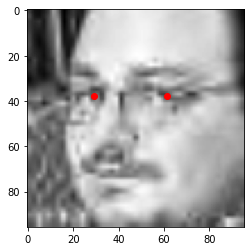

In [20]:
idx = 0
#Target Values 
target_vals = Y_batch[idx]

#Getting an image from the X_batch
img = X_batch[idx]

#Reshaping the image into a 96x96 and plotting it
plt.imshow(img[0], cmap='gray')

#Plotting the facial keypoints for the first 4 values 
plt.scatter(target_vals[0], target_vals[1], color='red')
plt.scatter(target_vals[2], target_vals[3], color='red')

**Using Pre-Trained Convolutional Neural Network**
- *Resnet18*
- *Resnet50*

In [21]:
#Using a pretrained model 
#model = torchvision.models.resnet18(pretrained = True)
model = torchvision.models.resnet50(pretrained = True) #2048 in features

#We need to modify the resnet to adapt to our problem, ImageNet has 1000 out_features
model.fc = torch.nn.Linear(in_features=2048, out_features=30) #In_features = 512 if resnet18 

In [22]:
device = torch.device("cpu")
model = model.to(device) #Directing our model to our device

In [23]:
loss_fun = torch.nn.MSELoss() #Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #Optimizer (Adam, SGD, RMSprop)

**Training the Neural Network**

In [24]:
#Training the Neural Network
num_epochs = 10
N_train = len(dataset_train)
N_test = len(dataset_val)

train_losses = [] #Collect training losses
test_losses = [] #Collect testing losses 

#For the number of epochs 
for ep in range(num_epochs):
    
    model.train() #Puts model in training mode
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch, Y_batch in dataloader_train: #Go through training data one batch at a time 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_onebatch = loss_fun(outputs,Y_batch)
        
        model.zero_grad()
        loss_onebatch.backward() #PyTorch computes gradient 
        optimizer.step() #One iteration of stochastic gradient descent / Adam 
        
        train_loss += loss_onebatch * N_batch
        
    model.eval() #Puts model in testing mode 
    test_loss = 0.0
    
    for X_batch, Y_batch in dataloader_val:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad(): #Tells pyTorch that it does not need to keep track of gradient info
            N_batch = X_batch.shape[0]
            outputs = model(X_batch) #Predictions 
            loss_onebatch = loss_fun(outputs,Y_batch)
            test_loss += loss_onebatch * N_batch
            
    train_losses.append(train_loss/N_train)
    test_losses.append(test_loss/N_train)
    
    print('Epoch : ', ep , '| Train Loss : ', train_loss/N_train, '| Test Loss : ', test_loss/N_train)
        

Epoch :  0 | Train Loss :  tensor(433.8598, grad_fn=<DivBackward0>) | Test Loss :  tensor(2.6480)
Epoch :  1 | Train Loss :  tensor(7.4271, grad_fn=<DivBackward0>) | Test Loss :  tensor(2.5607)
Epoch :  2 | Train Loss :  tensor(7.2036, grad_fn=<DivBackward0>) | Test Loss :  tensor(2.5065)
Epoch :  3 | Train Loss :  tensor(6.9332, grad_fn=<DivBackward0>) | Test Loss :  tensor(2.3772)
Epoch :  4 | Train Loss :  tensor(6.4013, grad_fn=<DivBackward0>) | Test Loss :  tensor(2.3021)
Epoch :  5 | Train Loss :  tensor(5.6989, grad_fn=<DivBackward0>) | Test Loss :  tensor(2.0815)
Epoch :  6 | Train Loss :  tensor(4.9195, grad_fn=<DivBackward0>) | Test Loss :  tensor(1.9819)
Epoch :  7 | Train Loss :  tensor(4.1852, grad_fn=<DivBackward0>) | Test Loss :  tensor(1.7225)
Epoch :  8 | Train Loss :  tensor(3.8210, grad_fn=<DivBackward0>) | Test Loss :  tensor(1.6494)
Epoch :  9 | Train Loss :  tensor(3.4088, grad_fn=<DivBackward0>) | Test Loss :  tensor(1.5031)


### Resnet18
#### **Optimization Algorithm** : *Adam*

> Without Data Augmentation 
>> **Learning Rate** : *0.001* 
*   **Epochs** : *10* , **Test Loss** : *1.7304*
*   **Epochs** : *15* , **Test Loss** : *1.2049*
*   **Epochs** : *20* , **Test Loss** : *1.3286*


>> **Learning Rate** : *0.01* 
*   **Epochs** : *10* , **Test Loss** : *2.3047*

> With Data Augmentation 
>> **Learning Rate** : *0.001* 
*   **Epochs** : *10* , **Test Loss** : *2.2037*
*   **Epochs** : *15* , **Test Loss** : *2.1073*
*   **Epochs** : *20* , **Test Loss** : *1.8039*


#### **Optimization Algorithm** : *RMSprop*
> Without Data Augmentation 
>> **Learning Rate** : *0.001* 
*   **Epochs** : *10* , **Test Loss** : *1.8473*
*   **Epochs** : *15* , **Test Loss** : *1.6015*
*   **Epochs** : *20* , **Test Loss** : *1.4367*


>> **Learning Rate** : *0.01* 
*   **Epochs** : *10* , **Test Loss** : *3.5082*



#### **Optimization Algorithm** : *SGD*
> Without Data Augmentation 
>> **Learning Rate** : *0.001* 
*   **Epochs** : *10* , **Test Loss** : *2.4679*
*   **Epochs** : *15* , **Test Loss** : *2.0740*
*   **Epochs** : *20* , **Test Loss** : *1.7995*


>> **Learning Rate** : *0.01* 
*   **Epochs** : *10* , **Test Loss** : *2.4421*


### Resnet50
#### **Optimization Algorithm** : *Adam*

> Without Data Augmentation 
>> **Learning Rate** : *0.001* 
*   **Epochs** : *5* , **Test Loss** : *2.3021*
*   **Epochs** : *10* , **Test Loss** : *1.5031*








**A plot of the Objective Function against the Epochs**

Text(0.5, 1.0, 'Objective Function vs Epoch')

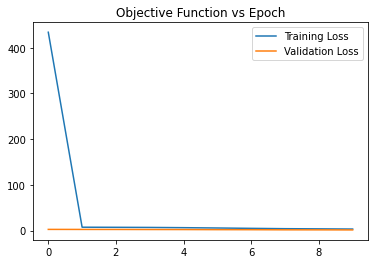

In [25]:
#Plot of the Objective Function against the Epochs for the Training and Validation Loss 
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Objective Function vs Epoch')

#training loss should always go down 

**Using our model on the validation dataset**

In [26]:
#Grabbing a batch of data from the validation dataset
X_val , Y_val = next(iter(dataloader_val))

X_val = X_val.to(device)
Y_val = Y_val.to(device)

with torch.no_grad(): #Tells pyTorch that it does not need to keep track of gradient info
    N_batch = X_val.shape[0]
    outputs = model(X_val) #Predictions 

outputs = outputs.cpu()

img_val = X_val[0].cpu().numpy()
validation_target_vals = outputs[0]

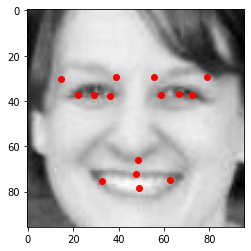

In [27]:
#Plotting an image from the validation dataset
plt.imshow(img_val[0], cmap='gray')

#Plotting the facial keypoints from the validation dataset
plt.scatter(validation_target_vals[0],validation_target_vals[1], color='red')
plt.scatter(validation_target_vals[2],validation_target_vals[3], color='red')
plt.scatter(validation_target_vals[4],validation_target_vals[5], color='red')
plt.scatter(validation_target_vals[6],validation_target_vals[7], color='red')
plt.scatter(validation_target_vals[8],validation_target_vals[9], color='red')
plt.scatter(validation_target_vals[10],validation_target_vals[11], color='red')
plt.scatter(validation_target_vals[12],validation_target_vals[13], color='red')
plt.scatter(validation_target_vals[14],validation_target_vals[15], color='red')
plt.scatter(validation_target_vals[16],validation_target_vals[17], color='red')
plt.scatter(validation_target_vals[18],validation_target_vals[19], color='red')
plt.scatter(validation_target_vals[20],validation_target_vals[21], color='red')
plt.scatter(validation_target_vals[22],validation_target_vals[23], color='red')
plt.scatter(validation_target_vals[24],validation_target_vals[25], color='red')
plt.scatter(validation_target_vals[26],validation_target_vals[27], color='red')
plt.scatter(validation_target_vals[28],validation_target_vals[29], color='red')

### **Using the test data to make predictions** 

In [28]:
#Reading in the test data
df_test = pd.read_csv(data_dir + 'test.csv')

In [29]:
#Dataset Class for the Test Data
class FacialKeyPointsTestDataset(torch.utils.data.Dataset):
    def __init__(self,df): #Initialisation Method 
        self.df = df 

    def __len__(self): #Length Method
        return len(self.df)
    
    def __getitem__(self,idx): #Get Item Method 
        row = self.df.iloc[idx]

        x = row['Image'].split(' ')
        x = np.float32(np.array(x)) #/255  (Normalised above so not needed here)
        
        #For a CNN, X needs to be a multidimensional array instead of a flat vector in a simple NN
        x = np.reshape(x, (96,96))

        x = np.stack((x,x,x), axis =2) #Albumentations wants it in shape (96,96,3)

      
        #PyTorch wants it in (3,96,96), so we need another reshape
        x = np.transpose(x, (2,0,1))
        
        return x

In [30]:
#Initialising our data with the Facial Key Points Test Dataset
dataset_test = FacialKeyPointsTestDataset(df_test)

#An empty array to store the images from the test set 
img_test = []

for i in range(len(dataset_test)):
  img_test.append(dataset_test.__getitem__(i))

X_test = img_test[0]
x_test = np.array(img_test,dtype='float32')

In [31]:
#Getting predictions for the test dataset
x_test = torch.tensor(x_test)
x_test = x_test.to(device)

with torch.no_grad(): #Tells pyTorch that it does not need to keep track of gradient info
    outputs = model(x_test) #Predictions 

outputs = outputs.cpu().detach().numpy() #Needs to be put back to the CPU 


img_val = x_test[0].cpu().numpy() #Needs to be put back to the CPU 
validation_target_vals = outputs[0]

In [32]:
#Predicted Values for the first image in the test set
outputs[0] 

array([238.17397 , 111.94281 ,  91.81104 , 135.10945 , 201.68765 ,
       124.68304 , 266.21906 , 122.96057 , 124.099304, 131.14162 ,
        54.527588, 138.88568 , 187.78519 ,  78.31195 , 286.14423 ,
        87.517654, 128.05762 ,  82.63454 ,  21.831757, 104.20499 ,
       195.3859  , 182.3313  , 227.73817 , 280.8397  , 110.03537 ,
       285.98697 , 172.15121 , 256.49524 , 192.98584 , 319.38535 ],
      dtype=float32)

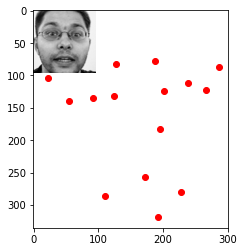

In [33]:
#Plotting an image from the test dataset
plt.imshow(img_val[0], cmap='gray')

#Plotting the facial keypoints from the test dataset
plt.scatter(validation_target_vals[0],validation_target_vals[1], color='red')
plt.scatter(validation_target_vals[2],validation_target_vals[3], color='red')
plt.scatter(validation_target_vals[4],validation_target_vals[5], color='red')
plt.scatter(validation_target_vals[6],validation_target_vals[7], color='red')
plt.scatter(validation_target_vals[8],validation_target_vals[9], color='red')
plt.scatter(validation_target_vals[10],validation_target_vals[11], color='red')
plt.scatter(validation_target_vals[12],validation_target_vals[13], color='red')
plt.scatter(validation_target_vals[14],validation_target_vals[15], color='red')
plt.scatter(validation_target_vals[16],validation_target_vals[17], color='red')
plt.scatter(validation_target_vals[18],validation_target_vals[19], color='red')
plt.scatter(validation_target_vals[20],validation_target_vals[21], color='red')
plt.scatter(validation_target_vals[22],validation_target_vals[23], color='red')
plt.scatter(validation_target_vals[24],validation_target_vals[25], color='red')
plt.scatter(validation_target_vals[26],validation_target_vals[27], color='red')
plt.scatter(validation_target_vals[28],validation_target_vals[29], color='red')